In [2]:
import sys
sys.path.append("../")

In [3]:
#local imports
import config
import constants
from models.smpl import get_smpl_model
from data.display_utils import display_model
from data.eft_dataset import EFTDataset

#package imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import cv2
from smplx.lbs import vertices2joints

In [3]:
data = np.load(config.MPIINF_ANNOT_FILE)

In [4]:
def npz_to_mine(imgname):
    parts = imgname.split("/")
    img = parts[-1].split("_")[-1]
    return os.path.join(parts[0],parts[1],parts[3],img)

Img from: /gpu-data/skar/MPIINF/mpi_inf_3dhp/S1/Seq1/video_0/000451.jpg


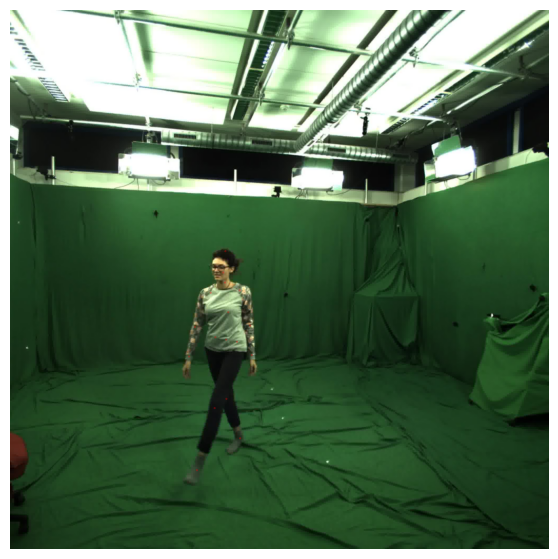

In [18]:
idx = 45
imgname = data['imgname'][idx]
part = data['part'][idx]
S = data['S'][idx]
openpose = data['openpose'][idx]
pose = torch.from_numpy(data['pose'][idx]).to(torch.float32).unsqueeze(0)
shape = torch.from_numpy(data['shape'][idx]).to(torch.float32).unsqueeze(0)

my_imgname = npz_to_mine(imgname)
my_imgname = os.path.join(config.MPIINF_IMAGE_FOLDER,my_imgname)
os.path.exists(my_imgname)
print("Img from:",my_imgname)

img = cv2.imread(my_imgname)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

for i in range(part.shape[0]):#processing only the 24 joints superset
    if part[i,2] > 0:
        color = (255,0,0)
        img = cv2.circle(img,center=(int(part[i][0]),int(part[i][1])),radius=3,color=color)

fig,ax = plt.subplots(1,1,figsize=(7,7))
ax.imshow(img)
ax.set_axis_off()

In [41]:
smpl = get_smpl_model(use_feet_keypoints=True,use_hands=True,extra=True,gender='male')

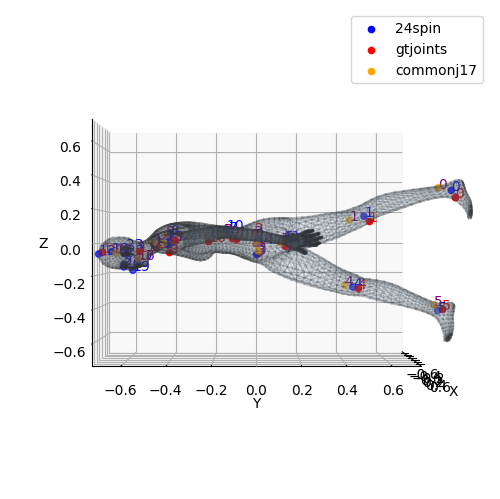

In [14]:
#display model
output = smpl(global_orient=pose[:,:3],body_pose=pose[:,3:],betas=shape)
#display last 24 joints of the model
j24 = output.joints[:,25:,:]
pelvis = j24[:,14].clone()
j24 -= pelvis
output.vertices -= pelvis

#display gt joints
S_t = torch.from_numpy(S).to(torch.float32).unsqueeze(0)
gt_joints = S_t[:,:,:3]
gt_joints_vis = S_t[:,:,3]
#(just out of curiosity) display the joints from the h36m regresosor
h36m_regressor = torch.from_numpy(np.load(config.JOINT_REGRESSOR_H36M)).to(torch.float32)
jh36m = vertices2joints(h36m_regressor,output.vertices)
j17 = jh36m[:,constants.H36M_TO_J17,:]
#the original 24 joints
j24orig = vertices2joints(smpl.J_regressor,output.vertices)
j17orig = j24orig[:,constants.J24_TO_J17,:]


ax = display_model(
            {'verts': output.vertices.cpu().detach(),
             'joints': output.joints.cpu().detach()},
            model_faces=smpl.faces.astype(int),
            with_joints=False,
            kintree_table=smpl.parents,
            savepath=None,
            show=False)
ax.view_init(elev=0,azim=0)

j24 = j24.detach().numpy()
gt_joints = gt_joints.numpy()
j17 = j17.detach().numpy()
j24orig = j24orig.detach().numpy()

ax.scatter3D(j24[0,:,0],j24[0,:,1],j24[0,:,2],c='blue',label='24spin')
for i in range(gt_joints.shape[1]):
    if gt_joints_vis[0,i] == 1.0:
        ax.scatter3D(gt_joints[0,i,0],gt_joints[0,i,1],gt_joints[0,i,2],c='red')
        ax.text(gt_joints[0,i,0],gt_joints[0,i,1],gt_joints[0,i,2],str(i),c='red')
    ax.text(*j24[0,i,:].tolist(),str(i),c='blue')
ax.scatter3D(gt_joints[0,0,0],gt_joints[0,0,1],gt_joints[0,0,2],c='red',label='gtjoints')

ax.scatter3D(j17[0,:,0],j17[0,:,1],j17[0,:,2],c='orange',label='commonj17')
for i in range(j17.shape[1]):
    ax.text(*j17[0,i].tolist(),str(i),c='purple')
#ax.scatter3D(j24orig[0,:,0],j24orig[0,:,1],j24orig[0,:,2],c='green',label='24original')



ax.legend()

Testing the mini eft annotations that i made

In [4]:
dataset = EFTDataset(datasets=['mpiinf'],is_train=False)

In [5]:
len(dataset)

96507

Data has smpl parameters


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Hidden 2d keypoints: [13, 15, 19, 20, 21, 22, 23]
Hidden 3d keypoints: [13, 15, 19, 20, 21, 22, 23]


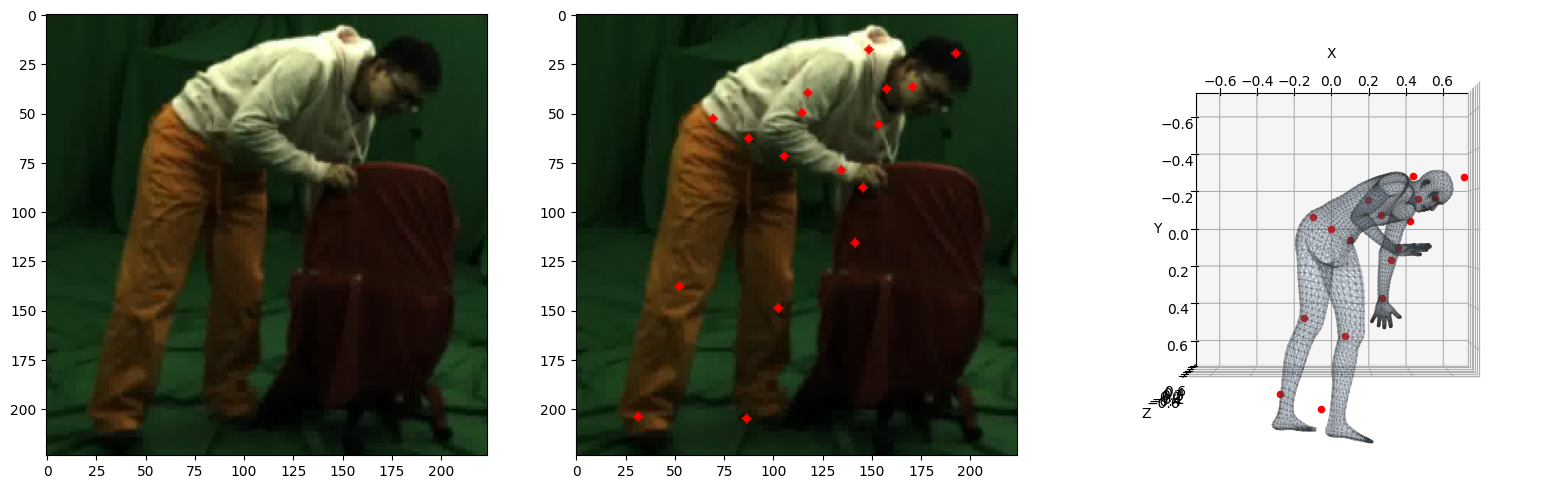

In [46]:
sample = dataset[80190]

pose = sample['pose']
shape = sample['shape']
keypoints3d = sample['keypoints3d']
visibility3d = sample['visibility3d']
keypoints2d = sample['keypoints2d']
visibility2d = sample['visibility2d']
has_smpl = sample['has_smpl']

mean=torch.tensor([0.485, 0.456, 0.406])
std=torch.tensor([0.229, 0.224, 0.225])
img = sample['img']*std.unsqueeze(-1).unsqueeze(-1) + mean.unsqueeze(-1).unsqueeze(-1)
img = img.permute(1,2,0).numpy()

if has_smpl:
    print("Data has smpl parameters")
    pose = pose.flatten(1,2).unsqueeze(0)
    output = smpl(global_orient=pose[:,:1,:],body_pose=pose[:,1:,:],betas=shape.unsqueeze(0),pose2rot=False)
    output.vertices -= output.joints[:,25+14]
else:
    output=None

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133,projection='3d')


ax1.imshow(img)
if output is not None:
    ax3 = display_model(
                {'verts': output.vertices.cpu().detach(),
                 'joints': output.joints[0,25:,:].cpu().detach()},
                model_faces=smpl.faces.astype(int),
                with_joints=False,
                kintree_table=smpl.parents,
                savepath=None,
                show=False,
                ax=ax3,
                alpha=0.1)

ax3.view_init(elev=-90,azim=-90,roll=0)

hidden2d = []
hidden3d = []

for i in range(keypoints3d.shape[0]):#processing only the 24 joints superset
    if visibility2d[25+i] > 0:
        color = (225,0,0)
        #if i ==8:
        #    color=(0,0,255)
        img = cv2.circle(img,center=(int(keypoints2d[25+i][0]),int(keypoints2d[25+i][1])),radius=2,color=color,thickness=-1)
    else:
        hidden2d.append(i)
    
    if visibility3d[i] > 0:
        c = 'red'
        #if i==8:
        #    c = 'blue'
        ax3.scatter3D(*keypoints3d[i].tolist(),c=c)
    else:
        hidden3d.append(i)

print("Hidden 2d keypoints:",hidden2d)
print("Hidden 3d keypoints:",hidden3d)

ax2.imshow(img)
